In [ ]:
from google import colab
colab.drive.mount('/content/drive')


Mounted at /content/drive


✅ Loaded: 300 rows
   Columns: ['Standard_Nepali', 'POS']

   Sample Standard_Nepali : प्रधानमन्त्री, केपी, शर्मा, ओली, ले, सिंहदरबार, मा, नयाँ, आर्थिक, नीति, सार्वजनिक, गरेका, छन्, ।
   Sample POS             : NOUN, PROPN, PROPN, PROPN, ADP, PROPN, ADP, ADJ, ADJ, NOUN, ADJ, VERB, AUX, PUNCT

📊 Validation:
   Total rows          : 300
   Matched rows        : 294
   Mismatched rows     : 6
   Total tokens        : 2756

⚠️  Mismatched rows (token ≠ label count):
   Row 9: tokens=11 labels=10
   Tokens : ['नेपाल', 'राष्ट्र', 'बैंक', 'ले', 'मौद्रिक']
   Labels : ['PROPN', 'PROPN', 'NOUN', 'ADP', 'ADJ']
   Row 19: tokens=11 labels=10
   Tokens : ['बागमती', 'प्रदेश', 'सरकार', 'ले', 'हेटौँडा']
   Labels : ['PROPN', 'NOUN', 'NOUN', 'ADP', 'PROPN']
   Row 20: tokens=6 labels=7
   Tokens : ['रमेश', 'तिमी', 'आज', 'काठमाडौं', 'जान्छौ']
   Labels : ['PROPN', 'PUNCT', 'PRON', 'ADV', 'PROPN']
   Row 21: tokens=7 labels=8
   Tokens : ['सीता', 'भोलि', 'पोखरा', 'मा', 'भेटौंला']
   Labels : ['PROPN', 

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaForTokenClassification LOAD REPORT from: wietsedv/xlm-roberta-base-ft-udpos28-en
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   ✅ Model loaded

   Predicting on 294 sentences...
   Processed 16 / 294
   Processed 32 / 294
   Processed 48 / 294
   Processed 64 / 294
   Processed 80 / 294
   Processed 96 / 294
   Processed 112 / 294
   Processed 128 / 294
   Processed 144 / 294
   Processed 160 / 294
   Processed 176 / 294
   Processed 192 / 294
   Processed 208 / 294
   Processed 224 / 294
   Processed 240 / 294
   Processed 256 / 294
   Processed 272 / 294
   Processed 288 / 294
   Processed 294 / 294

   Aligned → Gold: 2704 | Pred: 2704

🔍 SAMPLE PREDICTIONS (first 3 sentences)

  Sentence #1: प्रधानमन्त्री केपी शर्मा ओली ले सिंहदरबार मा नयाँ ...
  Token                      Gold       Pred     
  ------------------------------------------------
  प्रधानमन्त्री              NOUN      PROPN    ❌
  केपी                      PROPN      PROPN    ✅
  शर्मा                     PROPN      PROPN    ✅
  ओली                       PROPN      PROPN    ✅
  ले                          ADP        AUX    ❌
  सिंहदरबार    

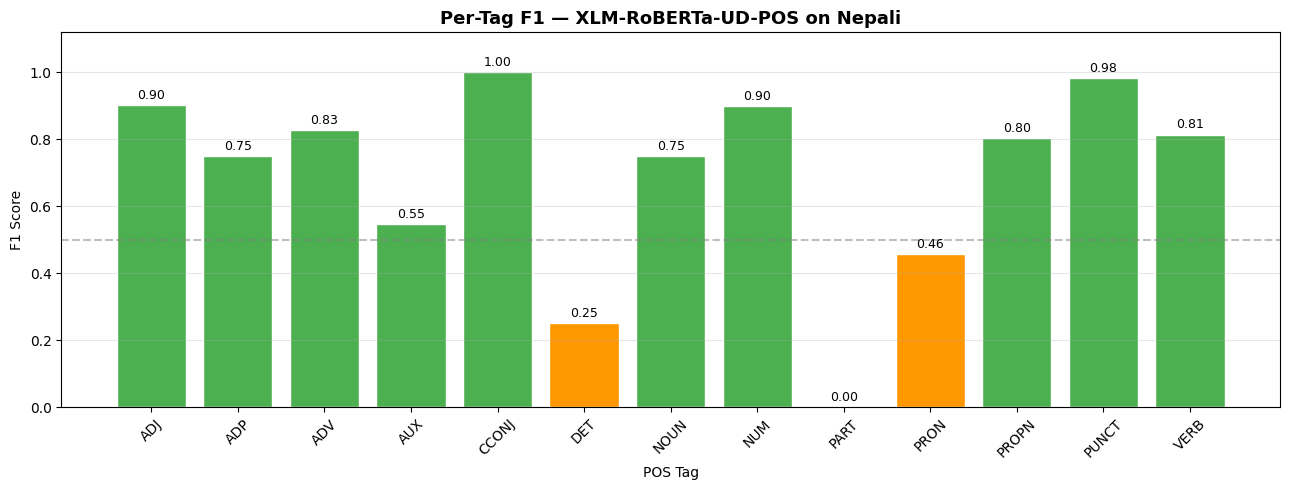

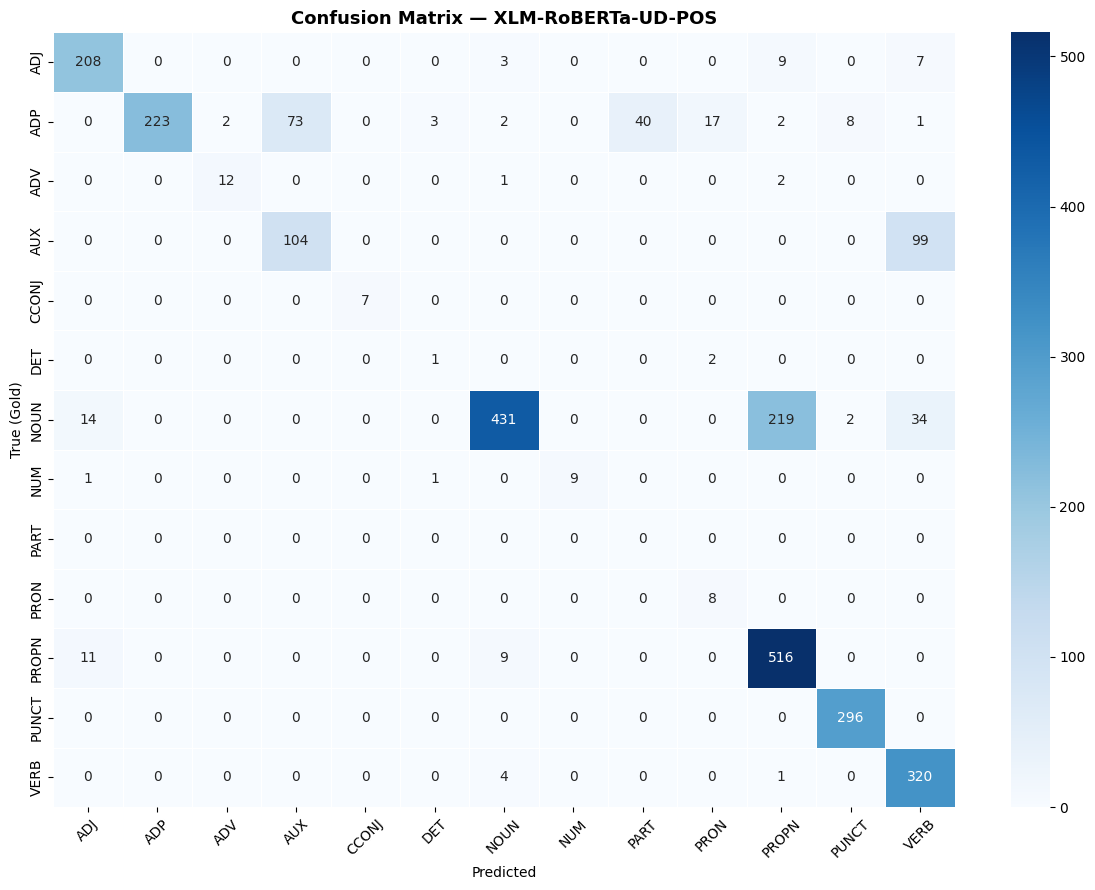

In [ ]:
# ============================================================
# Convert your existing CSV into model-ready format
# Input : Standard_Nepali (comma tokens) + POS (comma tags)
# Output: parsed_tokens list + parsed_labels list
# ============================================================

import pandas as pd
import ast

# ============================================================
# 1. LOAD YOUR CSV
# ============================================================

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/pos/nepali_datset.csv")   # ← change to your file name

print(f"✅ Loaded: {df.shape[0]} rows")
print(f"   Columns: {df.columns.tolist()}")
print(f"\n   Sample Standard_Nepali : {df.iloc[0]['Standard_Nepali']}")
print(f"   Sample POS             : {df.iloc[0]['POS']}")

# ============================================================
# 2. PARSE COMMA-SEPARATED TOKENS AND POS TAGS
#    Your data looks like:
#    Standard_Nepali: "प्रधानमन्त्री, केपी, शर्मा, ओली, ले,..."
#    POS            : "NOUN, PROPN, PROPN, PROPN, ADP,..."
# ============================================================

def parse_tokens(value):
    """Parse "प्रधानमन्त्री, केपी, शर्मा" → ['प्रधानमन्त्री','केपी','शर्मा']"""
    if pd.isna(value):
        return []
    return [t.strip() for t in str(value).split(",") if t.strip()]


def parse_pos(value):
    """Parse "NOUN, PROPN, PROPN" → ['NOUN','PROPN','PROPN']"""
    if pd.isna(value):
        return []
    return [t.strip() for t in str(value).split(",") if t.strip()]


df["parsed_tokens"] = df["Standard_Nepali"].apply(parse_tokens)
df["parsed_labels"] = df["POS"].apply(parse_pos)

# ============================================================
# 3. VALIDATE — token count must match label count
# ============================================================

df["token_count"] = df["parsed_tokens"].map(len)
df["label_count"] = df["parsed_labels"].map(len)
df["match"]       = df["token_count"] == df["label_count"]

print(f"\n📊 Validation:")
print(f"   Total rows          : {len(df)}")
print(f"   Matched rows        : {df['match'].sum()}")
print(f"   Mismatched rows     : {(~df['match']).sum()}")
print(f"   Total tokens        : {df['token_count'].sum()}")

# Show mismatched rows if any
mismatched = df[~df["match"]]
if len(mismatched) > 0:
    print(f"\n⚠️  Mismatched rows (token ≠ label count):")
    for i, row in mismatched.iterrows():
        print(f"   Row {i}: tokens={row['token_count']} "
              f"labels={row['label_count']}")
        print(f"   Tokens : {row['parsed_tokens'][:5]}")
        print(f"   Labels : {row['parsed_labels'][:5]}")

# Keep only matched rows
df_clean = df[df["match"]].reset_index(drop=True)
print(f"\n✅ Clean rows ready: {len(df_clean)}")

# ============================================================
# 4. BUILD FULL SENTENCE from tokens
#    Join tokens with space (for feeding into BERT model)
#    "प्रधानमन्त्री केपी शर्मा ओली ले सिंहदरबार मा..."
# ============================================================

df_clean["sentence"] = df_clean["parsed_tokens"].apply(
    lambda tokens: " ".join(tokens)
)

# ============================================================
# 5. SHOW SAMPLE — what your data looks like now
# ============================================================

print(f"\n{'='*65}")
print(f"📋 SAMPLE — First 3 rows")
print(f"{'='*65}")
for i in range(min(3, len(df_clean))):
    row = df_clean.iloc[i]
    print(f"\n  Row {i+1}:")
    print(f"  Sentence : {row['sentence'][:60]}...")
    print(f"  Tokens   : {row['parsed_tokens'][:5]}")
    print(f"  Labels   : {row['parsed_labels'][:5]}")
    print(f"  Count    : {row['token_count']} tokens")

# ============================================================
# 6. SAVE CLEAN VERSION
# ============================================================

# Save with parsed columns added
df_clean.to_csv("dataset_clean.csv", index=False)
print(f"\n💾 Saved → dataset_clean.csv ({len(df_clean)} rows)")

# ============================================================
# 7. NOW RUN THE MODEL DIRECTLY ON THIS
# ============================================================

print(f"\n{'='*65}")
print(f"🚀 Running POS evaluation on your dataset...")
print(f"{'='*65}")

import torch
from transformers import pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

MODEL_ID = "wietsedv/xlm-roberta-base-ft-udpos28-en"

# Load model
print(f"\n↻ Loading model: {MODEL_ID}")
nlp = pipeline(
    "token-classification",
    model                = MODEL_ID,
    aggregation_strategy = None,
    device               = 0 if torch.cuda.is_available() else -1
)
print("   ✅ Model loaded")

# ── Merge subwords → words ───────────────────────
def merge_subwords(raw_result):
    words, tags   = [], []
    current_word  = ""
    current_tag   = None
    for token in raw_result:
        piece = token["word"]
        tag   = token["entity"]
        if piece.startswith("▁"):
            if current_word:
                words.append(current_word)
                tags.append(current_tag)
            current_word = piece[1:]
            current_tag  = tag
        else:
            current_word += piece
    if current_word:
        words.append(current_word)
        tags.append(current_tag)
    return words, tags


# ── Get predictions ────────────────────────────────
def get_predictions(sentences, batch_size=16):
    print(f"\n   Predicting on {len(sentences)} sentences...")
    all_words, all_tags = [], []
    for i in range(0, len(sentences), batch_size):
        batch   = [str(s) for s in sentences[i:i+batch_size]
                   if pd.notna(s) and str(s).strip()]
        results = nlp(batch)
        if isinstance(results[0], dict):
            results = [results]
        for sent_result in results:
            w, t = merge_subwords(sent_result)
            all_words.append(w)
            all_tags.append(t)
        print(f"   Processed {min(i+batch_size, len(sentences))}"
              f" / {len(sentences)}")
    return all_words, all_tags


# ── Align model words → gold tokens ───────────────
def align(gold_tokens, gold_labels, pred_words, pred_tags):
    """
    Character-level alignment:
    gold: ['ओली','ले'] → joined: 'ओलीले'
    pred: ['ओलीले']    → joined: 'ओलीले'
    → match by characters, assign head morpheme tag
    """
    gold_joined = "".join(gold_tokens)
    pred_joined = "".join(pred_words)

    if len(gold_joined) == len(pred_joined):
        # Build char → pred_tag map
        char_to_tag = []
        for w, t in zip(pred_words, pred_tags):
            char_to_tag.extend([t] * len(w))

        aligned_pred = []
        char_pos = 0
        for tok in gold_tokens:
            tok_tags = char_to_tag[char_pos : char_pos + len(tok)]
            tag = (max(set(tok_tags), key=tok_tags.count)
                   if tok_tags else "X")
            aligned_pred.append(tag)
            char_pos += len(tok)
        return gold_labels, aligned_pred
    else:
        n = min(len(gold_tokens), len(gold_labels), len(pred_tags))
        return gold_labels[:n], pred_tags[:n]


# ── Run predictions ────────────────────────────────
sentences           = df_clean["sentence"].tolist()
all_words, all_tags = get_predictions(sentences, batch_size=16)

# ── Align all ─────────────────────────────────
gold_all, pred_all = [], []
for i, row in enumerate(df_clean.itertuples()):
    if i >= len(all_words):
        break
    g, p = align(row.parsed_tokens, row.parsed_labels,
                 all_words[i], all_tags[i])
    gold_all.append(g)
    pred_all.append(p)

total_gold = sum(len(g) for g in gold_all)
total_pred = sum(len(p) for p in pred_all)
print(f"\n   Aligned → Gold: {total_gold} | Pred: {total_pred}")

# ── Show 3 sample sentences ───────────────────────────
print(f"\n{'='*65}")
print(f"🔍 SAMPLE PREDICTIONS (first 3 sentences)")
print(f"{'='*65}")
for i in range(min(3, len(df_clean))):
    tokens = df_clean.iloc[i]["parsed_tokens"]
    gold   = gold_all[i]
    pred   = pred_all[i]
    n_show = min(len(tokens), len(gold), len(pred))

    print(f"\n  Sentence #{i+1}: "
          f"{df_clean.iloc[i]['sentence'][:50]}...")
    print(f"  {'Token':<22} {'Gold':>8} {'Pred':>10} {'':>4}")
    print(f"  {'-'*48}")
    correct = 0
    for tok, g, p in zip(tokens[:n_show], gold[:n_show], pred[:n_show]):
        mark = "✅" if g == p else "❌"
        if g == p:
            correct += 1
        print(f"  {tok:<22} {g:>8} {p:>10} {mark:>4}")
    pct = correct/n_show if n_show > 0 else 0
    print(f"  Accuracy: {correct}/{n_show} = {pct:.1%}")

# ── Evaluate ───────────────────────────────────────
flat_gold = [t for s in gold_all for t in s]
flat_pred = [t for s in pred_all for t in s]
labels    = sorted(set(flat_gold + flat_pred))

print(f"\n{'='*55}")
print(f"📊  EVALUATION RESULTS")
print(f"{'='*55}")
print(f"   {'Accuracy':<22} {accuracy_score(flat_gold, flat_pred):.4f}")
print(f"   {'Macro F1':<22} {f1_score(flat_gold, flat_pred, average='macro', labels=labels, zero_division=0):.4f}")
print(f"   {'Micro F1':<22} {f1_score(flat_gold, flat_pred, average='micro', labels=labels, zero_division=0):.4f}")
print(f"   {'Weighted F1':<22} {f1_score(flat_gold, flat_pred, average='weighted', labels=labels, zero_division=0):.4f}")
print(f"   {'Total Tokens':<22} {len(flat_gold)}")
from sklearn.metrics import precision_score, recall_score

macro_precision = precision_score(flat_gold, flat_pred,
                                  average="macro", zero_division=0)
macro_recall    = recall_score(flat_gold, flat_pred,
                               average="macro", zero_division=0)

print(f"Macro Precision : {macro_precision:.4f}")
print(f"Macro Recall    : {macro_recall:.4f}")
print(f"\n   Per-class Report:")
print(classification_report(flat_gold, flat_pred,
                            labels=labels, zero_division=0))

# ── Plots ───────────────────────────────────────
# Per-tag F1
scores = f1_score(flat_gold, flat_pred,
                  labels=sorted(set(flat_gold)),
                  average=None, zero_division=0)
tag_labels = sorted(set(flat_gold))
colors = ["#4CAF50" if s >= 0.5 else "#FF9800" if s >= 0.2
          else "#F44336" for s in scores]

plt.figure(figsize=(13, 5))
bars = plt.bar(tag_labels, scores, color=colors, edgecolor="white")
for bar, sc in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.01,
             f"{sc:.2f}", ha="center", va="bottom", fontsize=9)
plt.title("Per-Tag F1 — XLM-RoBERTa-UD-POS on Nepali",
          fontweight="bold", fontsize=13)
plt.xlabel("POS Tag")
plt.ylabel("F1 Score")
plt.ylim(0, 1.12)
plt.xticks(rotation=45)
plt.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(flat_gold, flat_pred,
                      labels=sorted(set(flat_gold)))
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=sorted(set(flat_gold)),
            yticklabels=sorted(set(flat_gold)),
            cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix — XLM-RoBERTa-UD-POS",
          fontweight="bold", fontsize=13)
plt.xlabel("Predicted")
plt.ylabel("True (Gold)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✅ Loaded: 300 rows
   Columns: ['Achhami_Dialect_Text ', 'POS']

   Sample achhami_Nepali : प्रधानमन्त्री, केपी, शर्मा, ओली, ले,सिंहदरबार, मा, नौलो, आर्थिक, नीति, सार्वजनिक, गर्याको, छ, ।
   Sample POS             : NOUN, PROPN, PROPN, PROPN, ADP, PROPN, ADP, ADJ, ADJ, NOUN, ADJ, VERB, AUX, PUNCT

📊 Validation:
   Total rows          : 300
   Matched rows        : 295
   Mismatched rows     : 5
   Total tokens        : 2826

⚠️  Mismatched rows (token ≠ label count):
   Row 5: tokens=13 labels=12
   Tokens : ['नेकपा', '(', 'माओवादी', ')', 'विपक्षी']
   Labels : ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ']
   Row 6: tokens=17 labels=18
   Tokens : ['सगरमाथा', 'क्षेत्रमा', 'पर्यटन', 'निको', 'बनाउन']
   Labels : ['PROPN', 'NOUN', 'NOUN', 'ADJ', 'VERB']
   Row 40: tokens=17 labels=18
   Tokens : ['सगरमाथा', 'नेपाल', 'र', 'चीन', 'को']
   Labels : ['PROPN', 'PROPN', 'CCONJ', 'PROPN', 'ADP']
   Row 133: tokens=7 labels=8
   Tokens : ['अनिश .पोखरा', 'को', 'फेवा', 'ताल', 'घुम्न']
   Labels : ['P

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaForTokenClassification LOAD REPORT from: wietsedv/xlm-roberta-base-ft-udpos28-en
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   ✅ Model loaded

   Predicting on 295 sentences...
   Processed 16 / 295
   Processed 32 / 295
   Processed 48 / 295
   Processed 64 / 295
   Processed 80 / 295
   Processed 96 / 295
   Processed 112 / 295
   Processed 128 / 295
   Processed 144 / 295
   Processed 160 / 295
   Processed 176 / 295
   Processed 192 / 295
   Processed 208 / 295
   Processed 224 / 295
   Processed 240 / 295
   Processed 256 / 295
   Processed 272 / 295
   Processed 288 / 295
   Processed 295 / 295

   Aligned → Gold: 2762 | Pred: 2762

🔍 SAMPLE PREDICTIONS (first 3 sentences)

  Sentence #1: प्रधानमन्त्री केपी शर्मा ओली ले सिंहदरबार मा नौलो ...
  Token                      Gold       Pred     
  ------------------------------------------------
  प्रधानमन्त्री              NOUN      PROPN    ❌
  केपी                      PROPN      PROPN    ✅
  शर्मा                     PROPN      PROPN    ✅
  ओली                       PROPN      PROPN    ✅
  ले                          ADP        AUX    ❌
  सिंहदरबार    

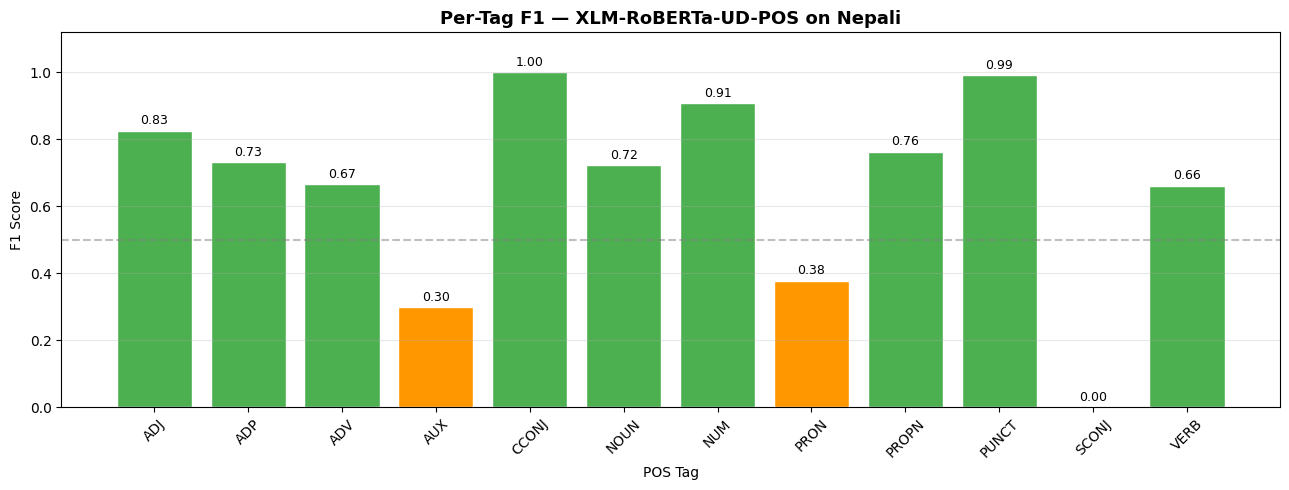

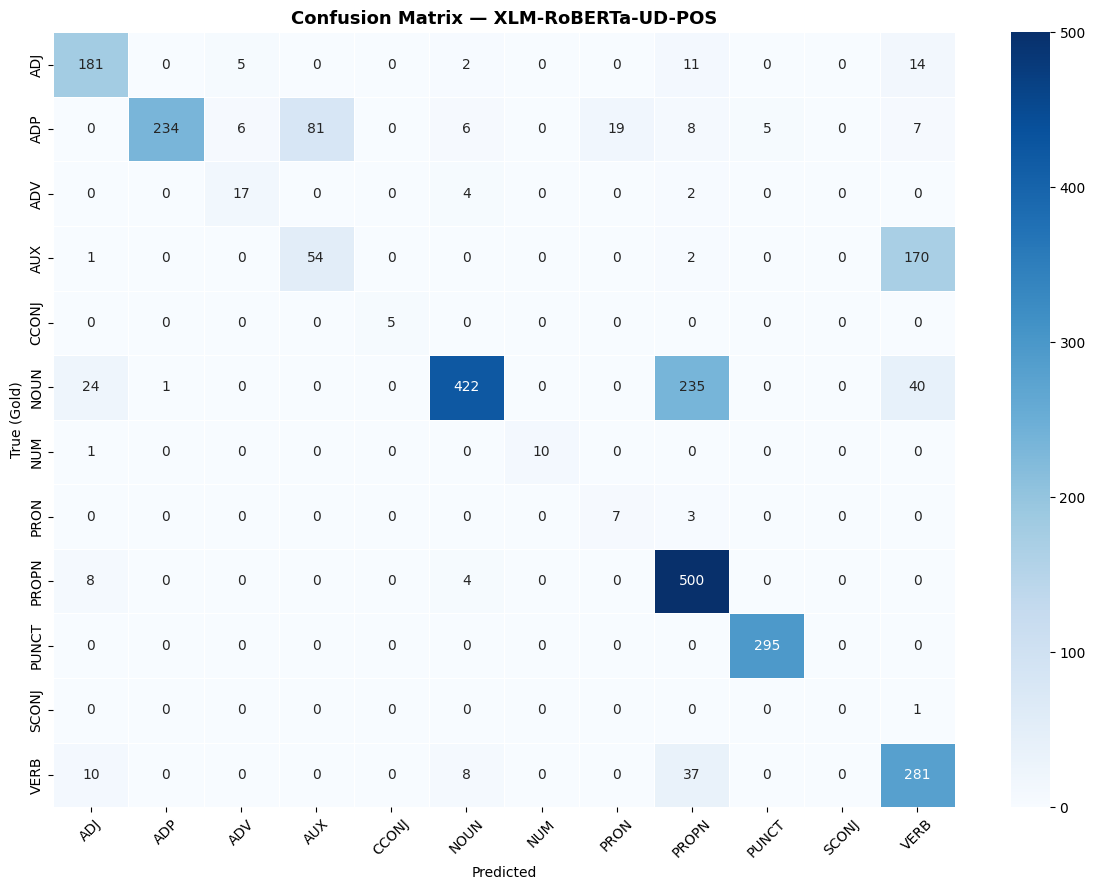

In [ ]:
# ============================================================
# Convert your existing CSV into model-ready format
# Input : Standard_Nepali (comma tokens) + POS (comma tags)
# Output: parsed_tokens list + parsed_labels list
# ============================================================

import pandas as pd
import ast

# ============================================================
# 1. LOAD YOUR CSV
# ============================================================

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/pos/achhami_dataset.csv")   # ← change to your file name

print(f"✅ Loaded: {df.shape[0]} rows")
print(f"   Columns: {df.columns.tolist()}")
print(f"\n   Sample achhami_Nepali : {df.iloc[0]['Achhami_Dialect_Text ']}")
print(f"   Sample POS             : {df.iloc[0]['POS']}")

# ============================================================
# 2. PARSE COMMA-SEPARATED TOKENS AND POS TAGS
#    Your data looks like:
#    Standard_Nepali: "प्रधानमन्त्री, केपी, शर्मा, ओली, ले,..."
#    POS            : "NOUN, PROPN, PROPN, PROPN, ADP,..."
# ============================================================

def parse_tokens(value):
    """Parse "प्रधानमन्त्री, केपी, शर्मा" → ['प्रधानमन्त्री','केपी','शर्मा']"""
    if pd.isna(value):
        return []
    return [t.strip() for t in str(value).split(",") if t.strip()]


def parse_pos(value):
    """Parse "NOUN, PROPN, PROPN" → ['NOUN','PROPN','PROPN']"""
    if pd.isna(value):
        return []
    return [t.strip() for t in str(value).split(",") if t.strip()]


df["parsed_tokens"] = df["Achhami_Dialect_Text "].apply(parse_tokens)
df["parsed_labels"] = df["POS"].apply(parse_pos)

# ============================================================
# 3. VALIDATE — token count must match label count
# ============================================================

df["token_count"] = df["parsed_tokens"].map(len)
df["label_count"] = df["parsed_labels"].map(len)
df["match"]       = df["token_count"] == df["label_count"]

print(f"\n📊 Validation:")
print(f"   Total rows          : {len(df)}")
print(f"   Matched rows        : {df['match'].sum()}")
print(f"   Mismatched rows     : {(~df['match']).sum()}")
print(f"   Total tokens        : {df['token_count'].sum()}")

# Show mismatched rows if any
mismatched = df[~df["match"]]
if len(mismatched) > 0:
    print(f"\n⚠️  Mismatched rows (token ≠ label count):")
    for i, row in mismatched.iterrows():
        print(f"   Row {i}: tokens={row['token_count']} "
              f"labels={row['label_count']}")
        print(f"   Tokens : {row['parsed_tokens'][:5]}")
        print(f"   Labels : {row['parsed_labels'][:5]}")

# Keep only matched rows
df_clean = df[df["match"]].reset_index(drop=True)
print(f"\n✅ Clean rows ready: {len(df_clean)}")

# ============================================================
# 4. BUILD FULL SENTENCE from tokens
#    Join tokens with space (for feeding into BERT model)
#    "प्रधानमन्त्री केपी शर्मा ओली ले सिंहदरबार मा..."
# ============================================================

df_clean["sentence"] = df_clean["parsed_tokens"].apply(
    lambda tokens: " ".join(tokens)
)

# ============================================================
# 5. SHOW SAMPLE — what your data looks like now
# ============================================================

print(f"\n{'='*65}")
print(f"📋 SAMPLE — First 3 rows")
print(f"{'='*65}")
for i in range(min(3, len(df_clean))):
    row = df_clean.iloc[i]
    print(f"\n  Row {i+1}:")
    print(f"  Sentence : {row['sentence'][:60]}...")
    print(f"  Tokens   : {row['parsed_tokens'][:5]}")
    print(f"  Labels   : {row['parsed_labels'][:5]}")
    print(f"  Count    : {row['token_count']} tokens")

# ============================================================
# 6. SAVE CLEAN VERSION
# ============================================================

# Save with parsed columns added
df_clean.to_csv("/content/drive/MyDrive/Colab Notebooks/dataset/pos/ach_dataset_clean.csv", index=False)
print(f"\n💾 Saved → dataset_clean.csv ({len(df_clean)} rows)")

# ============================================================
# 7. NOW RUN THE MODEL DIRECTLY ON THIS
# ============================================================

print(f"\n{'='*65}")
print(f"🚀 Running POS evaluation on your dataset...")
print(f"{'='*65}")

import torch
from transformers import pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

MODEL_ID = "wietsedv/xlm-roberta-base-ft-udpos28-en"

# Load model
print(f"\n↻ Loading model: {MODEL_ID}")
nlp = pipeline(
    "token-classification",
    model                = MODEL_ID,
    aggregation_strategy = None,
    device               = 0 if torch.cuda.is_available() else -1
)
print("   ✅ Model loaded")

# ── Merge subwords → words ───────────────────────
def merge_subwords(raw_result):
    words, tags   = [], []
    current_word  = ""
    current_tag   = None
    for token in raw_result:
        piece = token["word"]
        tag   = token["entity"]
        if piece.startswith("▁"):
            if current_word:
                words.append(current_word)
                tags.append(current_tag)
            current_word = piece[1:]
            current_tag  = tag
        else:
            current_word += piece
    if current_word:
        words.append(current_word)
        tags.append(current_tag)
    return words, tags


# ── Get predictions ────────────────────────────────
def get_predictions(sentences, batch_size=16):
    print(f"\n   Predicting on {len(sentences)} sentences...")
    all_words, all_tags = [], []
    for i in range(0, len(sentences), batch_size):
        batch   = [str(s) for s in sentences[i:i+batch_size]
                   if pd.notna(s) and str(s).strip()]
        results = nlp(batch)
        if isinstance(results[0], dict):
            results = [results]
        for sent_result in results:
            w, t = merge_subwords(sent_result)
            all_words.append(w)
            all_tags.append(t)
        print(f"   Processed {min(i+batch_size, len(sentences))}"
              f" / {len(sentences)}")
    return all_words, all_tags


# ── Align model words → gold tokens ───────────────
def align(gold_tokens, gold_labels, pred_words, pred_tags):
    """
    Character-level alignment:
    gold: ['ओली','ले'] → joined: 'ओलीले'
    pred: ['ओलीले']    → joined: 'ओलीले'
    → match by characters, assign head morpheme tag
    """
    gold_joined = "".join(gold_tokens)
    pred_joined = "".join(pred_words)

    if len(gold_joined) == len(pred_joined):
        # Build char → pred_tag map
        char_to_tag = []
        for w, t in zip(pred_words, pred_tags):
            char_to_tag.extend([t] * len(w))

        aligned_pred = []
        char_pos = 0
        for tok in gold_tokens:
            tok_tags = char_to_tag[char_pos : char_pos + len(tok)]
            tag = (max(set(tok_tags), key=tok_tags.count)
                   if tok_tags else "X")
            aligned_pred.append(tag)
            char_pos += len(tok)
        return gold_labels, aligned_pred
    else:
        n = min(len(gold_tokens), len(gold_labels), len(pred_tags))
        return gold_labels[:n], pred_tags[:n]


# ── Run predictions ───────────────────────────
sentences           = df_clean["sentence"].tolist()
all_words, all_tags = get_predictions(sentences, batch_size=16)

# ── Align all ─────────────────────────
gold_all, pred_all = [], []
for i, row in enumerate(df_clean.itertuples()):
    if i >= len(all_words):
        break
    g, p = align(row.parsed_tokens, row.parsed_labels,
                 all_words[i], all_tags[i])
    gold_all.append(g)
    pred_all.append(p)

total_gold = sum(len(g) for g in gold_all)
total_pred = sum(len(p) for p in pred_all)
print(f"\n   Aligned → Gold: {total_gold} | Pred: {total_pred}")

# ── Show 3 sample sentences ───────────────────────────
print(f"\n{'='*65}")
print(f"🔍 SAMPLE PREDICTIONS (first 3 sentences)")
print(f"{'='*65}")
for i in range(min(3, len(df_clean))):
    tokens = df_clean.iloc[i]["parsed_tokens"]
    gold   = gold_all[i]
    pred   = pred_all[i]
    n_show = min(len(tokens), len(gold), len(pred))

    print(f"\n  Sentence #{i+1}: "
          f"{df_clean.iloc[i]['sentence'][:50]}...")
    print(f"  {'Token':<22} {'Gold':>8} {'Pred':>10} {'':>4}")
    print(f"  {'-'*48}")
    correct = 0
    for tok, g, p in zip(tokens[:n_show], gold[:n_show], pred[:n_show]):
        mark = "✅" if g == p else "❌"
        if g == p:
            correct += 1
        print(f"  {tok:<22} {g:>8} {p:>10} {mark:>4}")
    pct = correct/n_show if n_show > 0 else 0
    print(f"  Accuracy: {correct}/{n_show} = {pct:.1%}")

# ── Evaluate ───────────────────────────
flat_gold = [t for s in gold_all for t in s]
flat_pred = [t for s in pred_all for t in s]
labels    = sorted(set(flat_gold + flat_pred))

print(f"\n{'='*55}")
print(f"📊  EVALUATION RESULTS")
print(f"{'='*55}")
print(f"   {'Accuracy':<22} {accuracy_score(flat_gold, flat_pred):.4f}")
print(f"   {'Macro F1':<22} {f1_score(flat_gold, flat_pred, average='macro', labels=labels, zero_division=0):.4f}")
print(f"   {'Micro F1':<22} {f1_score(flat_gold, flat_pred, average='micro', labels=labels, zero_division=0):.4f}")
print(f"   {'Weighted F1':<22} {f1_score(flat_gold, flat_pred, average='weighted', labels=labels, zero_division=0):.4f}")
print(f"   {'Total Tokens':<22} {len(flat_gold)}")
from sklearn.metrics import precision_score, recall_score

macro_precision = precision_score(flat_gold, flat_pred,
                                  average="macro", zero_division=0)
macro_recall    = recall_score(flat_gold, flat_pred,
                               average="macro", zero_division=0)

print(f"Macro Precision : {macro_precision:.4f}")
print(f"Macro Recall    : {macro_recall:.4f}")
print(f"\n   Per-class Report:")
print(classification_report(flat_gold, flat_pred,
                            labels=labels, zero_division=0))

# ── Plots ───────────────────────────
# Per-tag F1
scores = f1_score(flat_gold, flat_pred,
                  labels=sorted(set(flat_gold)),
                  average=None, zero_division=0)
tag_labels = sorted(set(flat_gold))
colors = ["#4CAF50" if s >= 0.5 else "#FF9800" if s >= 0.2
          else "#F44336" for s in scores]

plt.figure(figsize=(13, 5))
bars = plt.bar(tag_labels, scores, color=colors, edgecolor="white")
for bar, sc in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.01,
             f"{sc:.2f}", ha="center", va="bottom", fontsize=9)
plt.title("Per-Tag F1 — XLM-RoBERTa-UD-POS on Nepali",
          fontweight="bold", fontsize=13)
plt.xlabel("POS Tag")
plt.ylabel("F1 Score")
plt.ylim(0, 1.12)
plt.xticks(rotation=45)
plt.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(flat_gold, flat_pred,
                      labels=sorted(set(flat_gold)))
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=sorted(set(flat_gold)),
            yticklabels=sorted(set(flat_gold)),
            cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix — XLM-RoBERTa-UD-POS",
          fontweight="bold", fontsize=13)
plt.xlabel("Predicted")
plt.ylabel("True (Gold)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## POS Evaluation Results

This notebook evaluates the performance of the `wietsedv/xlm-roberta-base-ft-udpos28-en` model on two Nepali datasets: Standard Nepali and Achhami Dialect.

### 1. Standard Nepali Dataset Results

-   **Accuracy**: 0.7896
-   **Macro F1**: 0.6418
-   **Micro F1**: 0.7896
-   **Weighted F1**: 0.7911
-   **Macro Precision**: 0.6527
-   **Macro Recall**: 0.6817
-   **Total Tokens**: 2704

### 2. Achhami Dialect Dataset Results

-   **Accuracy**: 0.7263
-   **Macro F1**: 0.4969
-   **Micro F1**: 0.7263
-   **Weighted F1**: 0.7251
-   **Macro Precision**: 0.5113
-   **Macro Recall**: 0.5170
-   **Total Tokens**: 2762